In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [83]:
import pandas as pd
import numpy as np
import os

Read in data from csv file

Using the Neuroguide system (NG Deluxe 3.0.5; Applied Neuroscience, Inc., Largo, FL, USA), continuous EEG data were converted into the frequency domain using the fast Fourier transformation (FFT) with the following parameters: epoch = 2 s, sample rate = 128 samples/s (256 digital time points), frequency range = 0.5–40 Hz, and a resolution of 0.5 Hz with a cosine taper window to minimize leakage.

In [88]:
data = pd.read_csv('/content/drive/MyDrive/MLdata/EEG.machinelearing_data_BRMH.csv')
data.describe()

,no.,age,education,IQ,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
count,945.000000,945.000000,930.000000,932.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,...,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000
mean,473.000000,30.594804,13.438710,101.580472,20.182936,21.177584,17.749553,18.901698,20.447079,19.490329,...,75.889633,55.049113,56.959796,60.739169,69.829254,47.862489,66.832798,39.301406,66.153213,57.056207
std,272.942302,11.781592,2.550461,17.022414,11.282022,12.230662,10.003598,9.079482,9.742912,9.252500,...,15.861641,19.541956,18.326785,18.052887,17.725321,19.685722,17.028701,20.790933,18.088548,19.600107
min,1.000000,18.000000,0.000000,49.000000,3.272260,3.244199,3.050507,3.412618,5.066593,4.048931,...,12.611954,0.519048,6.926792,0.708008,2.421748,0.036664,1.032207,1.228502,0.363268,3.988805
25%,237.000000,21.730000,12.000000,91.000000,12.784872,13.019269,11.134327,12.460586,13.548645,12.637717,...,68.014443,41.607506,43.682444,48.374883,58.937785,32.581046,55.872070,22.049743,54.710605,43.955229
50%,473.000000,26.150000,13.000000,102.000000,17.065286,17.838251,15.541469,16.733004,18.065276,17.432568,...,78.647712,55.158858,56.657348,61.257972,72.298636,45.719426,68.238375,36.549938,67.988937,57.515871
75%,709.000000,35.450000,16.000000,114.000000,24.492760,25.654394,21.623961,23.347900,25.573096,23.956748,...,87.398387,69.740640,70.649245,73.979100,83.066877,62.081839,79.192418,54.169209,79.527764,71.626382
max,945.000000,71.880000,20.000000,145.000000,92.826192,101.515687,91.373456,82.544167,101.566662,77.197502,...,99.678649,100.000000,99.307895,100.000000,99.581629,98.720067,99.650154,98.413320,100.000000,99.287092


Clean data and remove irrelevant features

- Since the data is already converted from time domain to frequency domain, no FFT is required
- Split data into a labeled and unlabeled set for future uses
- Unlabeled contains only EEG frequencies while labeled contains an extra feature that contains mapping numbers that go from 1 - 5: 
1 -> MDD
2 -> schizophrenia
3 -> Control
4 -> Substance addiction
5 -> behavioral addiction
- Unlabeled data will be used for unsupervised learning

In [115]:

# replace the string values with int values: 1 -> MDD, 
# 2 -> schizophrenia, 3 -> Control, 4 -> Substance abuse, 
# 5 -> Behavioral addiction
def replace_values(data, label, oldValues, newValues):
  if len(oldValues) != len(newValues):
    raise Exception("Inconsistent replacement")

  for indexOf, value in enumerate(oldValues):
    data[label] = data[label].replace(value, newValues[indexOf])

  return data

def generate_disorder_control(data, label, disorders, control):
  newData = []
  for value in disorders:
    a = data.loc[data[label].isin([value, control])]
    newData.append(a)
  return newData


#Create datasets
frivolous_data = ['sex', 'age', 'eeg.date', 'education', 'IQ', 'main.disorder', 'no.']

labels = ['Depressive disorder', 'Schizophrenia', 'Healthy control', 'Alcohol use disorder', 'Behavioral addiction disorder']
label_map = [1, 2, 3, 4, 5]
disorders = ['Depressive disorder', 'Schizophrenia', 'Alcohol use disorder', 'Behavioral addiction disorder']

Disorders_EEG = data.drop(frivolous_data, axis=1)
labeled_disorder_control_set = generate_disorder_control(Disorders_EEG, 'specific.disorder', disorders, 'Healthy control')

Full_labeled = replace_values(Disorders_EEG, 'specific.disorder', labels, label_map)
Full_unlabeled = Full_labeled.drop('specific.disorder', axis=1)



Beginning with depression - healthy control dataset
- Run PCA to reduce dimensionality of the dataset
- Cluster with new features and measure distortion

In [154]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
Depression_Control = labeled_disorder_control_set[0].drop('specific.disorder', axis=1)
temp = Depression_Control.fillna(0)
#scaled_temp = StandardScaler().fit_transform(temp)

pca = PCA(0.95)
DR_DC = pca.fit_transform(temp)

In [142]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, init='k-means++')
reduced_clustering = kmeans.fit_predict(DR_DC)
non_reduced_clustering = kmeans.fit_predict(temp)

Visualization
- Because we lost well over 85 percent of our variance when reducing down a dimensionality that is plotable, this type of visualization is not optimal.

[0.32806921 0.10270321 0.05256423 0.04736793 0.04321581 0.02835859
 0.02563732 0.02262289 0.02035207 0.0186698  0.01527583 0.0137524
 0.01232744 0.01196648 0.01121472 0.01100858 0.01007878 0.00966505
 0.00857688 0.00779962 0.00731819 0.0069369  0.00645074 0.00630875
 0.00599001 0.00557771 0.0053339  0.00518774 0.00487607 0.00460554
 0.00454615 0.0042619  0.00398753 0.00390751 0.00371778 0.00346423
 0.00329453 0.0032404  0.00313139 0.00298454 0.00292107 0.00291558
 0.00268185 0.0025836  0.00251995 0.00240927 0.00235098 0.00223375
 0.00215898 0.00211256 0.00205072 0.00195009 0.0019122  0.00189188
 0.00183578 0.00181426 0.00174863 0.00159312 0.00150047 0.00147945
 0.00146002 0.00140202 0.00138439 0.00135043 0.00132749 0.00126983
 0.00121931 0.00120407 0.00111644]


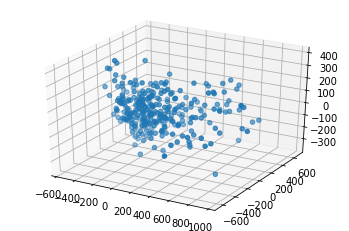

In [155]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(DR_DC[:,0], DR_DC[:,1], DR_DC[:,2])
print(pca.explained_variance_ratio_)